In [1]:
from google.colab import files
from IPython.display import Image
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR,ReduceLROnPlateau

import os
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


import myutils

In [5]:
cd '/gdrive/My Drive/Colab Notebooks/video_classify/'

/gdrive/My Drive/Colab Notebooks/video_classify


# Data Download and loading

In [5]:
#!wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

--2020-11-21 20:02:57--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2020-11-21 20:02:58--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  9.96MB/s    in 2m 37s  

2020-11-21 20:05:36 (12.9 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [ ]:
'''
for loading the data downloaded from https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/#Downloads
import os

directory = r"dataset/"
for filename in os.listdir(directory):
    if filename.endswith(".rar"):
        data = "dataset/" + filename
        dest = "dataset/" + filename[:-4] + "/"
        !unrar e $data $dest
    else:
        continue
'''

In [6]:
extension = ".avi"
n_frames = 16
sub_folder = "data"
sub_folder_jpg = "data_imgset"
folder = "dataset"

In [7]:

listOfCategories = os.listdir(folder)
listOfCategories, len(listOfCategories)

(['brush_hair',
  'shoot_gun',
  'sit',
  'situp',
  'smile',
  'smoke',
  'somersault',
  'stand',
  'swing_baseball',
  'sword',
  'sword_exercise',
  'talk',
  'throw',
  'turn',
  'walk',
  'wave',
  'cartwheel',
  'catch',
  'chew',
  'clap',
  'climb',
  'climb_stairs',
  'dive',
  'draw_sword',
  'dribble',
  'drink',
  'eat',
  'fall_floor',
  'fencing',
  'flic_flac',
  'golf',
  'handstand',
  'hit',
  'hug',
  'jump',
  'kick',
  'kick_ball',
  'kiss',
  'laugh',
  'pick',
  'pour',
  'pullup',
  'punch',
  'push',
  'pushup',
  'ride_bike',
  'ride_horse',
  'run',
  'shake_hands',
  'shoot_ball',
  'shoot_bow'],
 51)

In [8]:
for cat in listOfCategories[:2]:
    print("category:", cat)
    path2acat = os.path.join(folder, cat)
    listOfSubs = os.listdir(path2acat)
    print("number of sub-folders:", len(listOfSubs))
    print("-"*50)

category: brush_hair
number of sub-folders: 107
--------------------------------------------------
category: shoot_gun
number of sub-folders: 103
--------------------------------------------------


In [ ]:
'''
extension = ".avi"
n_frames = 16
sub_folder = "data"
sub_folder_jpg = "data_img"
for root, dirs, files in os.walk(folder, topdown=False):
    for name in files:
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, vlen = get_frames(path2vid, n_frames= n_frames)
        path2store = path2vid.replace(sub_folder, sub_folder_jpg)
        path2store = path2store.replace(extension, "")
        print(path2store)
        os.makedirs(path2store, exist_ok= True)
        myutils.store_frames(frames, path2store)
    print("-"*50)
'''

In [9]:
all_vids, all_labels, catgs = myutils.get_vids(sub_folder_jpg)
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [10]:
all_vids[:3], all_labels[:3], catgs[:5]

(['data_imgset/dribble/Basketball_Dribbling_-_Basketball_Dribbling-_Having_a_Good_Base_dribble_f_nm_np2_le_med_1',
  'data_imgset/dribble/American_History_X_dribble_f_cm_np1_le_bad_15',
  'data_imgset/dribble/Basic_Basketball_Moves_dribble_f_cm_np1_ba_goo_4'],
 ['dribble', 'dribble', 'dribble'],
 ['dribble', 'ride_bike', 'push', 'jump', 'hit'])

In [11]:
labels_dict = {}
ind = 0
for uc in catgs:
  labels_dict[uc] = ind
  ind+=1
labels_dict

{'brush_hair': 21,
 'cartwheel': 37,
 'catch': 38,
 'chew': 39,
 'clap': 40,
 'climb': 41,
 'climb_stairs': 42,
 'dive': 43,
 'draw_sword': 44,
 'dribble': 0,
 'drink': 45,
 'eat': 5,
 'fall_floor': 46,
 'fencing': 47,
 'flic_flac': 48,
 'golf': 49,
 'handstand': 6,
 'hit': 4,
 'hug': 19,
 'jump': 3,
 'kick': 16,
 'kick_ball': 7,
 'kiss': 10,
 'laugh': 9,
 'pick': 18,
 'pour': 20,
 'pullup': 8,
 'punch': 12,
 'push': 2,
 'pushup': 11,
 'ride_bike': 1,
 'ride_horse': 13,
 'run': 17,
 'shake_hands': 15,
 'shoot_ball': 14,
 'shoot_bow': 50,
 'shoot_gun': 22,
 'sit': 23,
 'situp': 24,
 'smile': 25,
 'smoke': 26,
 'somersault': 27,
 'stand': 28,
 'swing_baseball': 29,
 'sword': 30,
 'sword_exercise': 31,
 'talk': 32,
 'throw': 33,
 'turn': 34,
 'walk': 35,
 'wave': 36}

In [12]:
#selecting all the unique videos and classifying iy into 5 classes to simplify the problem
num_classes =5
unique_ids = [id_ for id_, label in zip(all_vids,all_labels)
if
labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels)
if
labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)


(642, 642)

In [13]:
#dividing the data into test and train


sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1,
random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))
train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))
test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))


577 577
65 65


# Defining the PyTorch datasets

In [14]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [15]:
path2imgs = "data_imgset"

In [16]:
class VideoDataset(Dataset):
  def __init__(self, ids, labels, transform):
    self.transform = transform
    self.ids = ids
    self.labels = labels
  def __len__(self):
    return len(self.ids)
  def __getitem__(self, idx):
    path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
    path2imgs = path2imgs[:timesteps]
    label = labels_dict[self.labels[idx]]
    frames = []
    for p2i in path2imgs:
      frame = Image.open(p2i)
      frames.append(frame)
    seed = np.random.randint(1e9)
    frames_tr = []
    for frame in frames:
      random.seed(seed)
      np.random.seed(seed)
      frame = self.transform(frame)
      frames_tr.append(frame)
    if len(frames_tr)>0:
      frames_tr = torch.stack(frames_tr)
    return frames_tr, label



In [17]:
model_type = "3dcnn"
timesteps =16
h, w = 112, 112
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]


In [18]:
import torchvision.transforms as transforms
train_transformer = transforms.Compose([transforms.Resize((h,w)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomAffine(degrees=0,
                                                                translate=(0.1,0.1)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std),])


In [19]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels,
transform= train_transformer)
print(len(train_ds))

577


In [20]:
imgs, label = train_ds[1]
if len(imgs)>0:
  print(imgs.shape, label, torch.min(imgs), torch.max(imgs))

torch.Size([16, 3, 112, 112]) 0 tensor(-1.8952) tensor(2.8736)


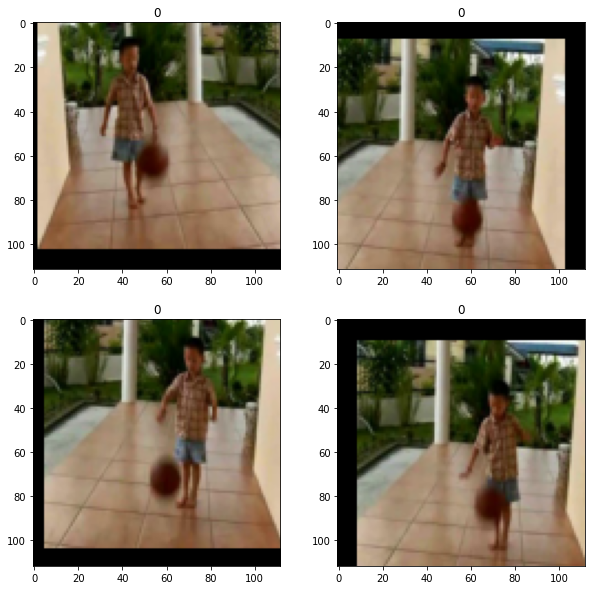

In [21]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
  plt.subplot(2,2,ii+1)
  plt.imshow(myutils.denormalize(img, mean, std))
  plt.title(label)


In [22]:
test_transformer = transforms.Compose([transforms.Resize((h,w)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std),])


In [23]:
test_ds = VideoDataset(ids= test_ids, labels= test_labels,
transform= test_transformer)
print(len(test_ds))


65


In [24]:
imgs, label = test_ds[1]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 112, 112]), 0, tensor(-1.8780), tensor(2.4679))

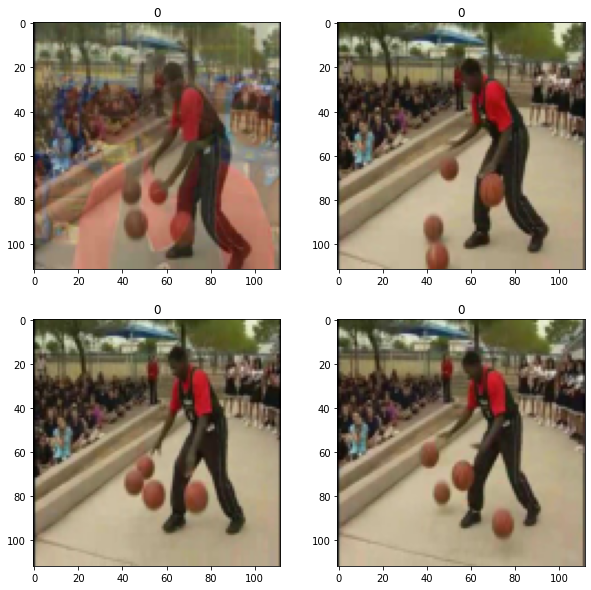

In [25]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
  plt.subplot(2,2,ii+1)
  plt.imshow(myutils.denormalize(img, mean, std))
  plt.title(label)

# Defining the data loaders

In [26]:
batch_size = 16

def collate_fn_3dcnn(batch):
  imgs_batch, label_batch = list(zip(*batch))
  imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
  label_batch = [torch.tensor(l) for l, imgs in zip(label_batch,
  imgs_batch) if len(imgs)>0]
  imgs_tensor = torch.stack(imgs_batch)
  imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
  labels_tensor = torch.stack(label_batch)
  return imgs_tensor,labels_tensor



train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn_3dcnn)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                     shuffle=False, collate_fn= collate_fn_3dcnn)


In [27]:
for xb,yb in train_dl:
  print(xb.shape, yb.shape)
  break


torch.Size([16, 3, 16, 112, 112]) torch.Size([16])


# Defining the model
The model is a  18-layer Resnet3D model, which was introduced in the following
article: A Closer Look at Spatio-temporal Convolutions for Action Recognition (https:/​/
arxiv.​org/​pdf/​1711.​11248.​pdf).



In [32]:
from torchvision import models
from torch import nn
model = models.video.r3d_18(pretrained=True, progress=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [33]:
with torch.no_grad():
  x = torch.zeros(1, 3, 16, h, w)
  y = model(x)
  print(y.shape)


torch.Size([1, 5])


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

# Training the model


In [36]:

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)


In [37]:
params_train={
"num_epochs": 20,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": test_dl,
"sanity_check": True,
"lr_scheduler": lr_scheduler,
"path2weights": "./models/weights_"+model_type+".pt",
}
model,loss_hist,metric_hist = myutils.train_val(model,params_train)


Epoch 0/19, current lr=3e-05


Copied best model weights!
train loss: 0.050480, dev loss: 0.827482, accuracy: 7.69
----------
Epoch 1/19, current lr=3e-05



Copied best model weights!
train loss: 0.053561, dev loss: 0.806489, accuracy: 12.31
----------
Epoch 2/19, current lr=3e-05



Copied best model weights!
train loss: 0.048650, dev loss: 0.786946, accuracy: 12.31
----------
Epoch 3/19, current lr=3e-05



Copied best model weights!
train loss: 0.044552, dev loss: 0.765474, accuracy: 13.85
----------
Epoch 4/19, current lr=3e-05


Copied best model weights!
train loss: 0.048291, dev loss: 0.745371, accuracy: 13.85
----------
Epoch 5/19, current lr=3e-05



Copied best model weights!
train loss: 0.043096, dev loss: 0.723538, accuracy: 15.38
----------
Epoch 6/19, current lr=3e-05



Copied best model weights!
train loss: 0.041203, dev loss: 0.704175, accuracy: 16.92
----------
Epoch 7/19, current lr=3e-05


Copied best model weights!
train loss: 0.043292, dev loss: 0.683802, accuracy: 18.46
----------
Epoch 8/19, current lr=3e-05


Copied best model weights!
train loss: 0.039692, dev loss: 0.665325, accuracy: 21.54
----------
Epoch 9/19, current lr=3e-05



Copied best model weights!
train loss: 0.039548, dev loss: 0.650596, accuracy: 20.00
----------
Epoch 10/19, current lr=3e-05


Copied best model weights!
train loss: 0.038118, dev loss: 0.634849, accuracy: 20.00
----------
Epoch 11/19, current lr=3e-05



Copied best model weights!
train loss: 0.030167, dev loss: 0.619468, accuracy: 21.54
----------
Epoch 12/19, current lr=3e-05



Copied best model weights!
train loss: 0.031438, dev loss: 0.603815, accuracy: 24.62
----------
Epoch 13/19, current lr=3e-05



Copied best model weights!
train loss: 0.032055, dev loss: 0.589254, accuracy: 27.69
----------
Epoch 14/19, current lr=3e-05


Copied best model weights!
train loss: 0.028449, dev loss: 0.576452, accuracy: 27.69
----------
Epoch 15/19, current lr=3e-05



Copied best model weights!
train loss: 0.030111, dev loss: 0.564332, accuracy: 27.69
----------
Epoch 16/19, current lr=3e-05



Copied best model weights!
train loss: 0.031581, dev loss: 0.552371, accuracy: 27.69
----------
Epoch 17/19, current lr=3e-05


Copied best model weights!
train loss: 0.032192, dev loss: 0.544826, accuracy: 30.77
----------
Epoch 18/19, current lr=3e-05


Copied best model weights!
train loss: 0.023811, dev loss: 0.531510, accuracy: 33.85
----------
Epoch 19/19, current lr=3e-05



Copied best model weights!
train loss: 0.030933, dev loss: 0.520925, accuracy: 32.31
----------


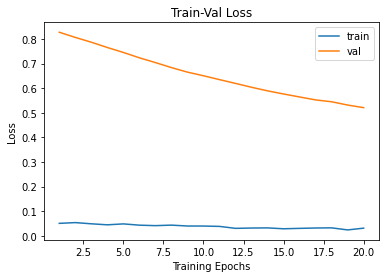

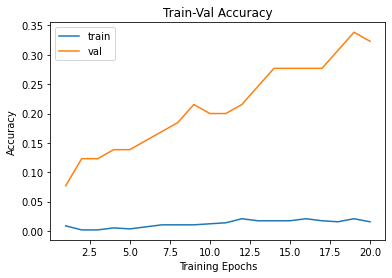

In [38]:
myutils.plot_loss(loss_hist, metric_hist)

# Deploying the video classification

In [39]:
import myutils
model_type = "3dcnn"
model = myutils.get_model(model_type = model_type, num_classes = 5)
model.eval();

the five classes that we trained are ['dribble', 'ride_bike', 'push', 'jump', 'hit']) so we take individual videos from the folder as see if it has been trained

In [45]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path2weights = "./models/weights_"+model_type+".pt"
model.load_state_dict(torch.load(path2weights))
model.to(device);
path2vido = "dataset/push/Alexander_pushing_the_table_push_f_cm_np1_ba_bad_1.avi"
frames, v_len = myutils.get_frames(path2vido, n_frames=16)
len(frames), v_len


(16, 79)

In [46]:
imgs_tensor = myutils.transform_frames(frames, model_type)
print(imgs_tensor.shape, torch.min(imgs_tensor),
torch.max(imgs_tensor))


torch.Size([1, 3, 16, 112, 112]) tensor(-1.8952) tensor(1.5615)


In [50]:
with torch.no_grad():
  out = model(imgs_tensor.to(device)).cpu()
  print(out.shape)
  pred = torch.argmax(out).item()
  print(pred)

for label, value in labels_dict.items():  
    if value == pred:
        print(label)

torch.Size([1, 5])
2
push


# References

https://sh-tsang.medium.com/paper-c3d-learning-spatiotemporal-features-with-3d-convolutional-networks-video-classification-72b49adb4081<br>
https://github.com/git-add-akshay/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py <br>
https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/#Downloads <br>
https://medium.com/@nair.binum/quick-overview-of-convolutional-3d-features-for-action-and-activity-recognition-c3d-138f96d58d8f <br>
https://arxiv.org/pdf/1711.11248.pdf